In [161]:
import os
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import shutil
import pyrouge
import logging
from collections import Counter, defaultdict


REF_FOLDER = '../cloud_data/baseline/decode_test_400maxenc_4beam_35mindec_100maxdec_ckpt-55092/reference/'
URL_LIST_FILE = '../prepare_data/cnn-dailymail/url_lists/small_test.txt'
CNN_STORY_DIR = '/Users/j.zhou/mlp_project/prepare_data/cnn-dailymail/cnn_stories_tokenized/'
DM_STORY_DIR = '/Users/j.zhou/mlp_project/prepare_data/cnn-dailymail/dm_stories_tokenized/'

CNN_STORY_HASH = set(os.listdir('../prepare_data/cnn/stories/'))
DM_STORY_HASH = set(os.listdir('../prepare_data/dailymail/stories/'))

VOCAB_PATH = '../data/finished_files/vocab'

with open(URL_LIST_FILE, 'r') as f:
    URL_LIST = f.readlines()

In [82]:
def get_ref(line_id):
    ref_folder = REF_FOLDER
    ref_path = os.path.join(ref_folder, '{:06d}_reference.txt'.format(line_id))
    with open(ref_path, 'r') as f:
        ref = ''.join(f.readlines())
    return ref

In [163]:
def compare_ref_decode(line_id, models):
    ref_folder = REF_FOLDER
    ref_path = os.path.join(ref_folder, '{:06d}_reference.txt'.format(line_id))
    with open(ref_path, 'r') as f:
        ref = ''.join(f.readlines())
    print('line_id %d: REF ' % line_id)
    print(ref)
    for model in models:
        model_path = os.path.join('../cloud_data/', model)
        file_paths = os.listdir(model_path)
        file_path = [path for path in file_paths if 'decode_test_400maxenc' in path][0]
        decode_file_path = os.path.join(model_path, file_path, 'decoded', '{:06d}_decoded.txt'.format(line_id))
        with open(decode_file_path, 'r') as f:
            decode = ''.join(f.readlines())
        print('=' * 15)
        print('model %s ' % model)
        print(decode)

def get_full_article(line_id):
    url = URL_LIST[line_id][:-1]
    def hashhex(s):
        """Returns a heximal formated SHA1 hash of the input string."""
        h = hashlib.sha1()
        h.update(s.encode())
        return h.hexdigest()
    story_filename = hashhex(url) + '.story'
    if story_filename in CNN_STORY_HASH:
        story_filename = os.path.join(CNN_STORY_DIR, story_filename)
    elif story_filename in DM_STORY_HASH:
        story_filename = os.path.join(DM_STORY_DIR, story_filename)
    else:
        raise ValueError
    with open(story_filename, 'r') as f:
        return ''.join(f.readlines())

In [151]:
def build_vocab_freq():
    cnt = Counter()
    n = 0
    with open(VOCAB_PATH, 'r') as f:
        for line in f:
            w, freq = line.strip().split(' ')
            cnt[w] = int(freq)
            n += 1
    return cnt

freq = build_vocab_freq()

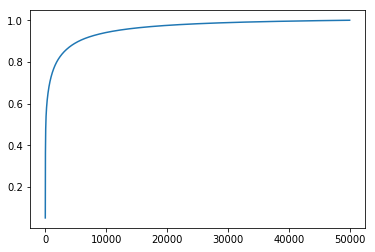

In [40]:
x = [tp[1] for tp in freq.most_common()[:50000]]
arr = np.cumsum(x)
plt.plot(range(len(x)), arr / arr[-1])
plt.show()

In [44]:
ratio = arr / arr[-1]
ratio[20000]

0.975339353121123

# EVAL rouge on subset

In [146]:
def rouge_eval(ref_dir, dec_dir):
    """Evaluate the files in ref_dir and dec_dir with pyrouge, returning results_dict"""
    r = pyrouge.Rouge155()
    r.model_filename_pattern = '#ID#_reference.txt'
    r.system_filename_pattern = '(\d+)_decoded.txt'
    r.model_dir = ref_dir
    r.system_dir = dec_dir
    logging.getLogger('global').setLevel(
        logging.WARNING)  # silence pyrouge logging
    rouge_results = r.convert_and_evaluate()
    return r.output_to_dict(rouge_results)

def eval_rouge_on_subset(ids, models):
    ret = {}
    for model in models:
        if os.path.exists('./tmp'):
            shutil.rmtree('tmp')
        os.mkdir('tmp')
        os.mkdir('tmp/dec')
        os.mkdir('tmp/ref')

        for new_i, i in enumerate(ids):
            src_ref = os.path.join(REF_FOLDER, '{:06d}_reference.txt'.format(i))

            model_path = os.path.join('../cloud_data/', model)
            file_paths = os.listdir(model_path)
            file_path = [path for path in file_paths if 'decode_test_400maxenc' in path][0]
            src_dec = os.path.join(model_path, file_path, 'decoded', '{:06d}_decoded.txt'.format(i))

            shutil.copyfile(src_ref, 'tmp/ref/{:06d}_reference.txt'.format(i))
            shutil.copyfile(src_dec, 'tmp/dec/{:06d}_decoded.txt'.format(i))
            
        ret[model] = rouge_eval('/Users/j.zhou/mlp_project/notebooks/tmp/ref',
                         '/Users/j.zhou/mlp_project/notebooks/tmp/dec')

        shutil.rmtree('tmp')
        
    return ret

rouge_scores = eval_rouge_on_subset(ids, ['baseline', 'char_concate', 'char_encoder'])

In [183]:
rouge_scores = eval_rouge_on_subset(new_ids, ['baseline', 'char_concate', 'char_encoder'])

In [185]:
rouge_scores_pos = eval_rouge_on_subset(new_ids, ['pos_concate', 'pos_encoder'])

# Filter Rare Words
let's define word after 40000 as rare words, words ranked after 50000 are UNK

In [170]:
unks = set(tp[0] for tp in freq.most_common()[50000:])

def extract_articles(words):
    ids, id_word_map = set(), defaultdict(set)
    for i in range(5000):
        article = get_full_article(i).split()
        for w in article:
            if w in words:
                ids.add(i)
                id_word_map[i].add(w)
    return ids, id_word_map

ids, id_word_map = extract_articles(unks)

In [181]:
new_ids = []
for id_ in id_word_map:
    if len(id_word_map[id_]) > 5:
        new_ids.append(id_)

In [192]:
print(get_full_article(3))

Chances are you 've been to Malaga . Well , the airport at any rate . Every year , millions of us pass through on the way to the beaches of the Costa del Sol or palaces of Granada .

But , now , the southern Spanish port is having a moment .

Thanks to a multi-million pound regeneration project , and several new galleries and museums , this once down-at-heel city has become one of Europe 's hippest destinations .

Incoming : The Centre Pompidou Malaga , a pop-up version of the Parisian institution , has opened to visitors

Along with a thriving cultural scene , there are good restaurants , great shopping and exciting nightlife .

This week saw the opening of Centre Pompidou Malaga , the first of several popup versions of the famous Parisian gallery planned outside France .

It is housed in a low-slung white building topped with a giant glass cube in the trendy harbour area .

When I turn up , a large crowd is queuing to pay the £ 6.70 entrance fee to view 90 works by artists such as Mi

In [194]:
compare_ref_decode(8, ['baseline', 'char_concate', 'char_encoder'])

line_id 8: REF 
c.j miles and george hill were in impressive form during win over wizards .
pacers have chance of making fifth straight playoff appearance .
la lakers won final game in regular season against phoenix suns .
model baseline 
indiana pacers guard c.j. miles scored 25 points during his side 's vital win over the washington wizards .
george hill also played a major role in the pacers ' victory against the wizards at the bankers life fieldhouse .
the clippers clinched the west 's no 3 seed with the win .
model char_concate 
the pacers -lrb- 38-43 -rrb- have won six straight games and will make a fifth straight playoff appearance if they win at memphis .
martin gortat and bradley beal each scored 19 points for the wizards -lrb- 46-35 -rrb- .
indiana pacers guard c.j. miles scored 25 points during his side 's vital win over the washington wizards .
model char_encoder 
indiana pacers guard c.j. miles scored 25 points for indiana pacers guard c.j. miles scored 25 points .
george 

In [198]:
id_word_map[306]

{'137,000',
 'bejewelled',
 'diamantes',
 'fringing',
 'gilet',
 'high-impact',
 'jewelled',
 'ombre',
 'plimsolls',
 'tassel',
 'unpick',
 'waisted'}

In [195]:
print(get_full_article(8))

C.J. Miles scored 25 points and George Hill added 24 to lead a 7-2 spurt to open the second overtime on Tuesday as Indiana kept their playoff hopes alive with a 99-95 victory over Washington .

The Pacers -LRB- 38-43 -RRB- have won six straight games and will make a fifth straight playoff appearance if they win at Memphis - or if Brooklyn loses to Orlando - on the final night of the regular season .

Martin Gortat and Bradley Beal each scored 19 points for the Wizards -LRB- 46-35 -RRB- .

Indiana Pacers guard C.J. Miles scored 25 points during his side 's vital win over the Washington Wizards

George Hill also played a major role in the Pacers ' victory against the Wizards at the Bankers Life Fieldhouse

It was a grind for the Pacers , who struggled shooting all night and trailed 70-61 with 7:07 left .

They rallied to take a late 79-75 lead , then Washington forced overtime . Indiana did n't lead again until Hill 's mid-range jumper 23 seconds into the second overtime made it 87-85 . 

# POS can handle name

In [6]:
print(get_full_article(456))

She has already taken the modelling world by storm, being snapped up to front campaigns for The Upside, Myer, Berlei and ASOS, to name a few.

And now like Megan Gale, Jennifer Hawkins and Elle Macpherson before her, plus-size queen Laura Wells has turned her hand to designing.

The brunette bombshell has launched a new swimwear line with a twist - the eco-friendly collection is made entirely of 100 per cent recycled material.

Scroll down for video  

Curves to coral: Model and environmental scientist Laura Wells uses figure to flaunt ocean inspired swimwear 

Sizzling: The Australian beauty smoulders in the campaign

The environmental scientist turned model designed the line in collaboration with US brand Swimsuits For All's trend range, SwimSexy.

The collection is inspired by the ocean, with coral reef scenes featuring throughout.

The line includes one and two-piece suits, with zippers, criss-cross straps, plunging V-necklines and high-waisted bottoms.

The swimsuits cater for eve

In [5]:
compare_ref_decode(456, ['baseline', 'baseline_coverage', 'char_concate', 'char_concate_coverage', 'pos_concate', 'pos_concate_coverage'])

line_id 456: REF 
australian plus size model laura wells releases eco-friendly swimwear .
the swim range goes up to size 24 and is 100 per cent recyclable material .
the prints australian ocean inspired designs and coral reef colours .
the swimwear is a collaboration with us brand swim sexy .
model baseline 
model and environmental scientist uses figure to flaunt ocean inspired swimwear .
the collection is inspired by the ocean , with coral reef scenes featuring throughout .
the swimsuits cater for every shape , with sizes ranging from 10 through to 24 .
model baseline_coverage 
the brunette bombshell has launched a new swimwear line with a twist - the eco-friendly collection is made entirely of 100 per cent recycled material .
the brunette bombshell has launched a new swimwear line with a twist - the eco-friendly collection is made entirely of 100 per cent recycled material .
model char_concate 
the collection is inspired by the ocean , with coral reef scenes featuring throughout .
th

In [ ]:
import sys
sys.path.append('../pointer-generator/pos_tagger/')
from pos_tagging import get_POS_tagged_sent

In [ ]:
get_POS_tagged_sent('Model and environmental scientist Laura Wells uses figure to flaunt ocean inspired swimwear .'.split())

In [ ]:
compare_ref_decode(4777, ['baseline', 'pos_encoder', 'char_concate'])

In [ ]:
article = get_full_article(4978)